In [1]:
import time
import json
import asyncio
import concurrent.futures
import requests
import matplotlib.pyplot as plt

# RECEIPT_NUMBER_BASE = "EAC2090"
# RANGE_START = 108700
# RANGE_END = 114300
# CASE_TYPE = 'I-765'
CONCURRENCY_LEVEL = 11

In [2]:
def check_status(receipt_num):
    #print(receipt_num)
    pload = {"appReceiptNum": receipt_num, "initCaseSearch":"CHECK STATUS"}
    r = requests.post('https://egov.uscis.gov/casestatus/mycasestatus.do', data=pload)
    if (r.status_code != 200):
        print("Error with {0}, code {1}".format(receipt_num, r.status_code))
        return None
    
    response = r.text.split("\n")
    return (receipt_num, response[719].strip())
    
    
def save_plot(status_list):
    x, y = zip(*status_list)
    plt.scatter(x, y)
    plt.show()
    plt.savefig('UscisStats.png', bbox_inches='tight')

In [7]:
with open('today.json') as f:
    yday = json.load(f)
with open('yday.json','w') as f:
    json.dump(yday, f)
    
len(yday)

1480

<Figure size 432x288 with 0 Axes>

<Task pending name='Task-4' coro=<main() running at <ipython-input-8-569a7d847173>:5>>

Running total 134 batches
 - processing batch No.0, the job has took 0.00 seconds.
 - processing batch No.10, the job has took 86.94 seconds.
 - processing batch No.20, the job has took 179.44 seconds.
 - processing batch No.30, the job has took 224.85 seconds.
 - processing batch No.40, the job has took 285.91 seconds.
 - processing batch No.50, the job has took 327.26 seconds.
 - processing batch No.60, the job has took 406.30 seconds.
 - processing batch No.70, the job has took 463.96 seconds.
 - processing batch No.80, the job has took 552.14 seconds.
 - processing batch No.90, the job has took 607.92 seconds.
 - processing batch No.100, the job has took 676.88 seconds.
 - processing batch No.110, the job has took 747.81 seconds.
 - processing batch No.120, the job has took 813.25 seconds.
 - processing batch No.130, the job has took 898.34 seconds.
1480


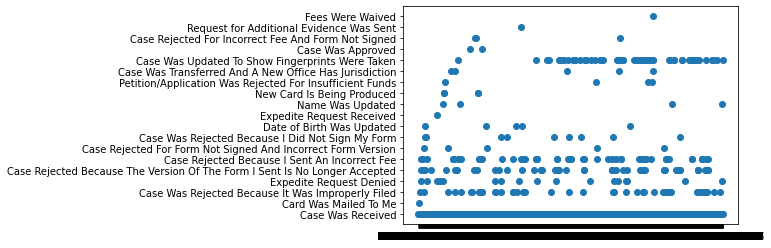

In [8]:
status_list = []

# yday=[('EAC2090108729', ''), ('EAC2090114277', '')]

async def main():
    #num_digits = len(str(RANGE_END))

    loop = asyncio.get_event_loop()
    #batches = int((RANGE_END - RANGE_START) / CONCURRENCY_LEVEL + 1)
    batches = int(len(yday)/CONCURRENCY_LEVEL)
    print("Running total {} batches".format(batches))
    start = time.time()
    for i in range(batches):
        if i % 10 == 0:
            seconds = time.time() - start
            print(" - processing batch No.{0}, the job has took {1:.2f} seconds.".format(i, seconds))
            #print(" - Has found I-765: {}".format(len(status_list)))
        
        batch_start = CONCURRENCY_LEVEL * i
        #print(batch_start)
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=CONCURRENCY_LEVEL) as executor:
            
            futures = [
                loop.run_in_executor(
                    executor,
                    check_status,
                    yday[batch_start+x][0]
                )
                for x in range(CONCURRENCY_LEVEL)
            ]
            for t in await asyncio.gather(*futures):
                if t is not None:
                    status_list.append(t)
    
    
    if batches*CONCURRENCY_LEVEL < len(yday):
        batch_start = CONCURRENCY_LEVEL * batches
        batch_num = len(yday) - CONCURRENCY_LEVEL * batches
#         print(batch_start, batch_num)
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=batch_num) as executor:
            futures = [
                loop.run_in_executor(
                    executor,
                    check_status,
                    yday[batch_start+x][0]
                )
                for x in range(batch_num)
            ]
#             print('A')
            for t in await asyncio.gather(*futures):
                if t is not None:
                    status_list.append(t)
                    
    print(len(status_list))
                    
    #print('{0} takes {1:.2f}% in the range.'.format(CASE_TYPE, 100*len(status_list)/(batches*CONCURRENCY_LEVEL)))

    save_plot(status_list)


loop = asyncio.get_event_loop()
loop.create_task(main())

In [16]:
def statistic():
    diff = []
    approved = []
    for i in range(len(yday)):
        if (yday[i][1] != status_list[i][1]):
            diff.append((yday[i][0], yday[i][1], status_list[i][1]))
        if (status_list[i][1] == "Case Was Approved" or status_list[i][1] == "New Card Is Being Produced"):
            approved.append(status_list[i])
    
    print('Case Changed total: {}'.format(len(diff)))
    for case_num, s_from, s_to in diff:
        print(" - Case: {0}, status changed from {1} to {2}".format(case_num, s_from, s_to))
    
    print('Case approved total: {0}, takes {1:.2f}% of 1480 cases'.format(len(approved), len(approved)/1480))
    for case_num, ap_status in approved:
        print(' - ' + case_num, ap_status)
        
statistic()

Case Changed total: 7
 - Case: EAC2090109172, status changed from Case Was Received to Name Was Updated
 - Case: EAC2090109175, status changed from Case Was Received to New Card Is Being Produced
 - Case: EAC2090109176, status changed from Case Was Received to New Card Is Being Produced
 - Case: EAC2090109482, status changed from Case Was Received to Name Was Updated
 - Case: EAC2090109737, status changed from Case Was Received to New Card Is Being Produced
 - Case: EAC2090109738, status changed from Case Was Received to New Card Is Being Produced
 - Case: EAC2090109829, status changed from Case Was Received to Case Was Approved
Case approved total: 6, takes 0.00% of 1480 cases
 - EAC2090109175 New Card Is Being Produced
 - EAC2090109176 New Card Is Being Produced
 - EAC2090109636 Case Was Approved
 - EAC2090109737 New Card Is Being Produced
 - EAC2090109738 New Card Is Being Produced
 - EAC2090109829 Case Was Approved


In [17]:
with open('today.json','w') as f:
    json.dump(status_list, f)
    
len(status_list)
    

1480